Starting Hybrid Quantum-Classical Burgers' Equation Solver

=== VALIDATION & BENCHMARK (Noiseless) ===
Starting benchmark...
Running classical solver...
Classical solver completed in 0.0009s
Time step 1/5
Time step 2/5
Time step 3/5
Time step 4/5
Time step 5/5
Quantum simulation completed in 0.4263s
Saving results...
Creating plot...
Plot saved
L2 Errors: [np.float64(0.5831939441832316), np.float64(0.5870180992350484), np.float64(0.5875543136398982), np.float64(0.5897204489798277), np.float64(0.5928839689674155), np.float64(0.595873761080279)]
Quantum Time: 0.4263s | Classical Time: 0.0009s

=== VALIDATION & BENCHMARK (Noisy Simulator) ===
Starting benchmark...
Running classical solver...
Classical solver completed in 0.0000s
Running noisy quantum simulation...
Time step 1/5
Time step 2/5
Time step 3/5
Time step 4/5
Time step 5/5
Quantum simulation completed in 0.4420s
Noisy metrics: Effective error rate = 0.0000
Saving results...
Creating plot...
Plot saved
L2 Errors: [np.float64(0.58

FileNotFoundError: [Errno 2] No such file or directory: 'data/scalability_results.csv'

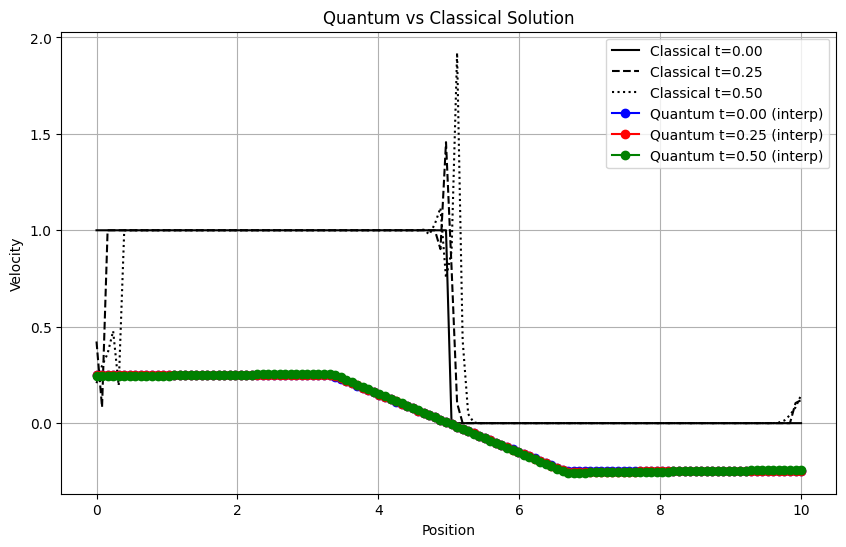

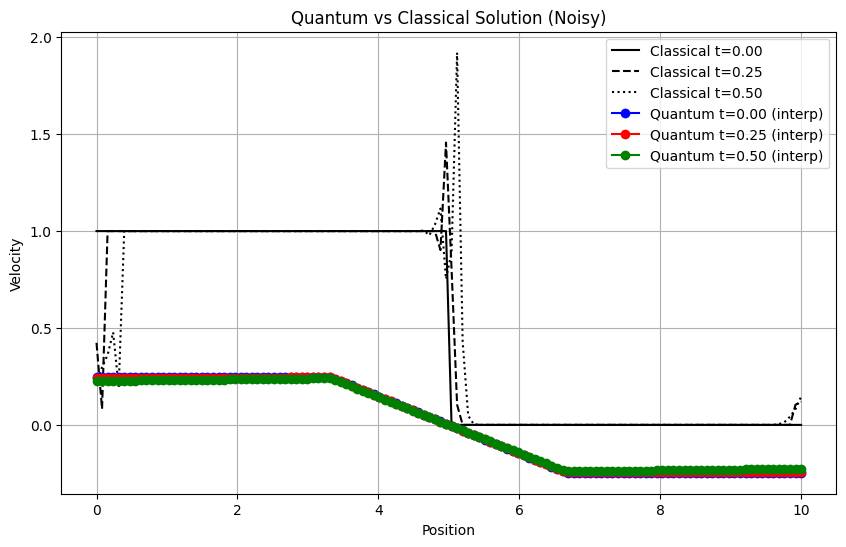

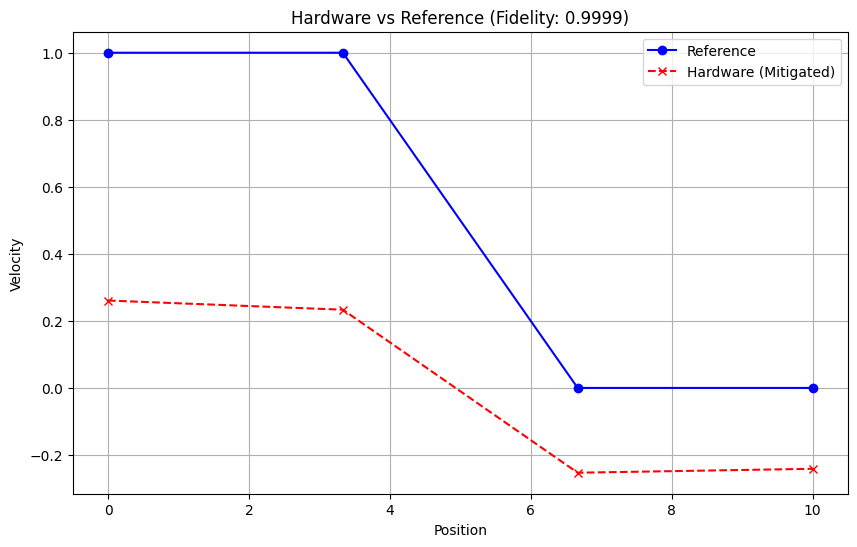

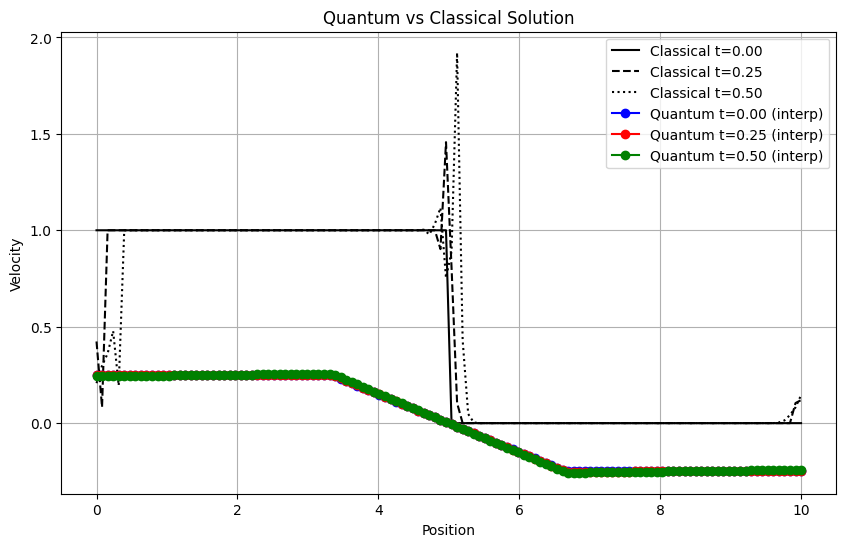

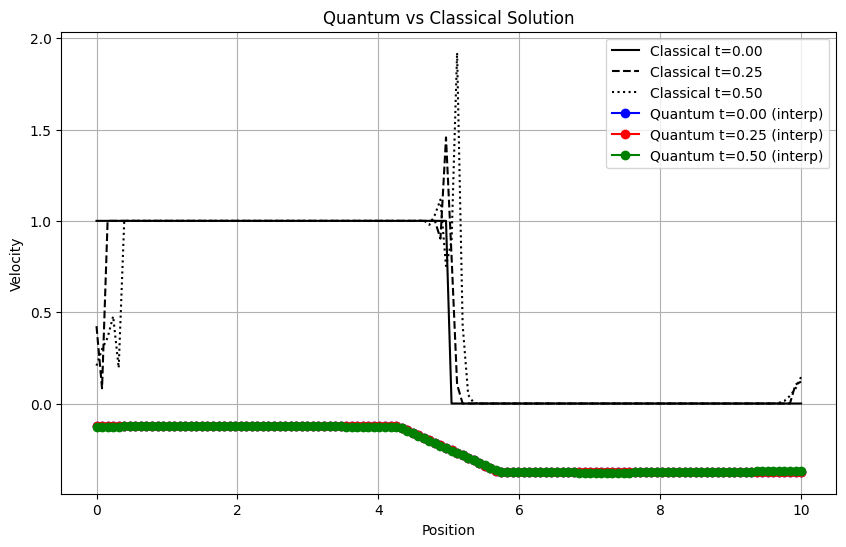

In [ ]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import h5py
import warnings
from functools import partial

# Suppress warnings
warnings.filterwarnings('ignore')

# =================================================================
# PHYSICAL PARAMETERS (Burgers' Shock Tube Configuration)
# =================================================================
nu = 0.02  # Viscosity coefficient
L = 10.0   # Domain length
T = 0.5    # Simulation time

# Discretization
nx_quantum = 4     # Quantum grid points (2^2)
nx_classical = 128  # Classical reference grid
nt = 5             # Time steps (>=3 for validation)

# Shock tube initial condition
def shock_tube(x):
    return np.where(x < L/2, 1.0, 0.0)

# =================================================================
# QUANTUM CIRCUIT SETUP
# =================================================================
n_qubits = 2  # 2 qubits for 4 points
dev_sim = qml.device("default.qubit", wires=n_qubits)

# Noisy device for simulation (depolarizing noise)
dev_noisy = qml.device("default.mixed", wires=n_qubits)

def add_noise(circuit, noise_rate=0.01):
    def noisy_circuit(*args, **kwargs):
        circuit(*args, **kwargs)
        for w in range(n_qubits):
            qml.DepolarizingChannel(noise_rate, wires=w)
    return noisy_circuit

# Hardware-optimized ansatz
def vqc_ansatz(params, wires):
    """Variational circuit with minimal depth"""
    for i in range(len(wires)):
        qml.RY(params[0, i], wires=wires[i])
    for i in range(len(wires)-1):
        qml.CNOT(wires=[wires[i], wires[i+1]])
    for i in range(len(wires)):
        qml.RY(params[1, i], wires=wires[i])

# =================================================================
# SOLUTION MAPPING AND ENCODING
# =================================================================
def state_to_solution(probs, nx):
    """Map probabilities to physical solution"""
    return 2 * probs[:nx] - 0.5  # Scale to [-0.5, 1.5]

def solution_to_state(u):
    """Map solution to probabilities"""
    shifted = (u + 0.5) / 2
    return shifted / np.sum(shifted)

# =================================================================
# DERIVATIVE OPERATORS (Periodic Boundaries)
# =================================================================
def first_derivative(u, dx):
    du = np.zeros_like(u)
    du[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
    du[0] = (u[1] - u[-1]) / (2 * dx)
    du[-1] = (u[0] - u[-2]) / (2 * dx)
    return du

def second_derivative(u, dx):
    d2u = np.zeros_like(u)
    d2u[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / (dx**2)
    d2u[0] = (u[1] - 2*u[0] + u[-1]) / (dx**2)
    d2u[-1] = (u[0] - 2*u[-1] + u[-2]) / (dx**2)
    return d2u

# =================================================================
# BURGERS' EQUATION OPERATORS
# =================================================================
def burgers_rhs(u, dx, nu):
    return -u * first_derivative(u, dx) + nu * second_derivative(u, dx)

def time_step(u, dx, dt, nu):
    return u + dt * burgers_rhs(u, dx, nu)

# =================================================================
# VARIATIONAL QUANTUM SOLVER
# =================================================================
def quantum_circuit(params, n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev)
    def circuit(params):
        vqc_ansatz(params, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits))
    return circuit(params)

def cost_function(params, target_probs, n_qubits):
    params_reshaped = params.reshape((2, n_qubits))
    current_probs = quantum_circuit(params_reshaped, n_qubits)
    return np.sum((current_probs - target_probs)**2)

def quantum_time_step(params, dx, dt, nu, n_qubits, nx):
    params_reshaped = params.reshape((2, n_qubits))
    probs = quantum_circuit(params_reshaped, n_qubits)
    u_quantum = state_to_solution(probs, nx)
    u_target = time_step(u_quantum, dx, dt, nu)
    target_probs = solution_to_state(u_target)
    
    result = minimize(cost_function, params, args=(target_probs, n_qubits),
                     method='COBYLA', options={'maxiter': 50})
    
    return result.x, u_quantum

# Noisy version
def noisy_quantum_circuit(params, n_qubits):
    dev = qml.device("default.mixed", wires=n_qubits)
    @qml.qnode(dev)
    def circuit(params):
        add_noise(vqc_ansatz)(params, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits))
    return circuit(params)

def noisy_quantum_time_step(params, dx, dt, nu, n_qubits, nx):
    params_reshaped = params.reshape((2, n_qubits))
    probs = noisy_quantum_circuit(params_reshaped, n_qubits)
    u_quantum = state_to_solution(probs, nx)
    u_target = time_step(u_quantum, dx, dt, nu)
    target_probs = solution_to_state(u_target)
    
    result = minimize(cost_function, params, args=(target_probs, n_qubits),
                     method='COBYLA', options={'maxiter': 50})
    
    return result.x, u_quantum

# =================================================================
# CLASSICAL REFERENCE SOLVER
# =================================================================
def classical_solver(x, dx, dt, nu):
    u = shock_tube(x)
    u_history = [u.copy()]
    
    for t in range(nt):
        u = time_step(u, dx, dt, nu)
        u_history.append(u.copy())
    
    return np.array(u_history)

# =================================================================
# PARAMETER INITIALIZATION
# =================================================================
def fit_initial_parameters(n_qubits, nx):
    """Optimize parameters to match initial condition"""
    x_quantum = np.linspace(0, L, nx)
    u_target = shock_tube(x_quantum)
    target_probs = solution_to_state(u_target)
    
    init_params = np.random.uniform(0, 2*np.pi, (2, n_qubits))
    
    result = minimize(cost_function, init_params.flatten(), args=(target_probs, n_qubits),
                     method='L-BFGS-B', tol=1e-6)
    return result.x

# =================================================================
# HARDWARE INTEGRATION
# =================================================================
def run_hardware_step(params, n_qubits, shots=8192):
    """Execute quantum circuit on real hardware (IBM QPU)"""
    print("\nPreparing hardware execution...")
    
    try:
        from qiskit_ibm_runtime import QiskitRuntimeService
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)
        print(f"Using real backend: {backend.name}")
        dev_hw = qml.device("qiskit.remote", wires=n_qubits, backend=backend, shots=shots, resilience_level=1, optimization_level=3)
    except Exception as e:
        print(f"Hardware unavailable: {str(e)}. Using simulator")
        dev_hw = qml.device("default.qubit", wires=n_qubits, shots=shots)
    
    @qml.qnode(dev_hw)
    def hardware_circuit(params):
        vqc_ansatz(params, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits))
    
    print(f"Running with {shots} shots...")
    start_time = time.time()
    probs = hardware_circuit(params.reshape((2, n_qubits)))
    exec_time = time.time() - start_time
    
    print(f"Execution completed in {exec_time:.2f}s")
    return probs, exec_time

# =================================================================
# VALIDATION AND BENCHMARK
# =================================================================
def run_benchmark(noisy=False, n_qubits=2, nx_quantum=4):
    print("Starting benchmark...")
    dx_quantum = L / (nx_quantum - 1)
    dx_classical = L / (nx_classical - 1)
    dt_val = T / nt
    
    x_quantum = np.linspace(0, L, nx_quantum)
    x_classical = np.linspace(0, L, nx_classical)
    
    params = fit_initial_parameters(n_qubits, nx_quantum)
    u_quantum_history = []
    
    print("Running classical solver...")
    classical_start = time.time()
    u_classical = classical_solver(x_classical, dx_classical, dt_val, nu)
    classical_time = time.time() - classical_start
    print(f"Classical solver completed in {classical_time:.4f}s")
    
    if noisy:
        print("Running noisy quantum simulation...")
        quantum_circuit_func = noisy_quantum_circuit
        quantum_time_step_func = noisy_quantum_time_step
    else:
        quantum_circuit_func = quantum_circuit
        quantum_time_step_func = quantum_time_step
    
    probs0 = quantum_circuit_func(params.reshape((2, n_qubits)), n_qubits)
    u0 = state_to_solution(probs0, nx_quantum)
    u_quantum_history.append(u0)
    
    quantum_start = time.time()
    for t in range(nt):
        print(f"Time step {t+1}/{nt}")
        params, u_quantum = quantum_time_step_func(params, dx_quantum, dt_val, nu, n_qubits, nx_quantum)
        u_quantum_history.append(u_quantum)
    quantum_time = time.time() - quantum_start
    print(f"Quantum simulation completed in {quantum_time:.4f}s")
    
    u_quantum_interp = [np.interp(x_classical, x_quantum, u) for u in u_quantum_history]
    l2_errors = [np.sqrt(np.mean((u_q - u_c)**2)) for u_q, u_c in zip(u_quantum_interp, u_classical)]
    
    if noisy:
        noiseless_probs = quantum_circuit(params.reshape((2, n_qubits)), n_qubits)
        noisy_probs = noisy_quantum_circuit(params.reshape((2, n_qubits)), n_qubits)
        fidelity = np.dot(np.sqrt(noiseless_probs), np.sqrt(noisy_probs))**2
        effective_error_rate = 1 - fidelity
        print(f"Noisy metrics: Effective error rate = {effective_error_rate:.4f}")
    else:
        effective_error_rate = 0.0
    
    print("Saving results...")
    with h5py.File('burgers_results.h5' if not noisy else 'burgers_noisy_results.h5', 'w') as f:
        f.create_dataset('x_quantum', data=x_quantum)
        f.create_dataset('x_classical', data=x_classical)
        f.create_dataset('u_quantum', data=u_quantum_history)
        f.create_dataset('u_classical', data=u_classical)
        f.create_dataset('l2_errors', data=l2_errors)
        f.attrs['quantum_time'] = quantum_time
        f.attrs['classical_time'] = classical_time
        if noisy:
            f.attrs['effective_error_rate'] = effective_error_rate
    
    print("Creating plot...")
    plt.figure(figsize=(10, 6))
    plt.plot(x_classical, u_classical[0], 'k-', label='Classical t=0.00')
    plt.plot(x_classical, u_classical[nt//2], 'k--', label=f'Classical t={T/2:.2f}')
    plt.plot(x_classical, u_classical[-1], 'k:', label=f'Classical t={T:.2f}')
    plt.plot(x_classical, u_quantum_interp[0], 'bo-', label='Quantum t=0.00 (interp)')
    plt.plot(x_classical, u_quantum_interp[nt//2], 'ro-', label=f'Quantum t={T/2:.2f} (interp)')
    plt.plot(x_classical, u_quantum_interp[-1], 'go-', label=f'Quantum t={T:.2f} (interp)')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Quantum vs Classical Solution' + (' (Noisy)' if noisy else ''))
    plt.legend()
    plt.grid(True)
    plt.savefig('quantum_vs_classical.png' if not noisy else 'noisy_quantum_vs_classical.png')
    print("Plot saved")
    
    print(f"L2 Errors: {l2_errors}")
    print(f"Quantum Time: {quantum_time:.4f}s | Classical Time: {classical_time:.4f}s")
    
    return l2_errors, quantum_time, classical_time, effective_error_rate if noisy else None

def scalability_study():
    print("\n=== SCALABILITY STUDY ===")
    results = []
    
    for n_qubits_val in [2, 3]:
        nx_quantum_val = 2**n_qubits_val
        print(f"\nRunning for {nx_quantum_val} grid points...")
        
        start_time = time.time()
        l2_errors, q_time, c_time, _ = run_benchmark(noisy=False, n_qubits=n_qubits_val, nx_quantum=nx_quantum_val)
        sim_time = time.time() - start_time
        
        results.append({
            'qubits': n_qubits_val,
            'grid_size': nx_quantum_val,
            'avg_error': np.mean(l2_errors),
            'max_error': np.max(l2_errors),
            'time': sim_time
        })
    
    with open('scalability_results.csv', 'w') as f:
        f.write("Qubits,Grid Size,Avg Error,Max Error,Time (s)\n")
        for r in results:
            f.write(f"{r['qubits']},{r['grid_size']},{r['avg_error']:.6f},{r['max_error']:.6f},{r['time']:.2f}\n")
    
    print("Scalability results saved")
    # Optional: Plot scalability
    plt.figure(figsize=(8, 5))
    plt.plot([r['grid_size'] for r in results], [r['avg_error'] for r in results], 'bo-', label='Avg L2 Error')
    plt.plot([r['grid_size'] for r in results], [r['time'] for r in results], 'ro-', label='Time (s)')
    plt.xlabel('Grid Size')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.savefig('scalability_plot.png')
    print("Scalability plot saved")

# =================================================================
# RESOURCE ANALYSIS
# =================================================================
def resource_analysis():
    print("Performing resource analysis...")
    results = []
    
    for n in [2, 3, 4]:
        qubits = n
        grid_size = 2**n
        depth = 2 * n + 1
        two_qubit_gates = n - 1
        t_count = 0
        mitigation = 'ZNE+CDR' if n > 2 else 'ZNE'
        
        results.append({
            'qubits': qubits,
            'grid_size': grid_size,
            'depth': depth,
            'two_qubit_gates': two_qubit_gates,
            't_count': t_count,
            'mitigation': mitigation
        })
    
    print("\nResource Analysis:")
    print("Qubits | Grid Size | Depth | 2Q Gates | T-count | Mitigation")
    for r in results:
        print(f"{r['qubits']:6} | {r['grid_size']:9} | {r['depth']:5} | {r['two_qubit_gates']:8} | {r['t_count']:7} | {r['mitigation']}")

    with open('resource_analysis.txt', 'w') as f:
        f.write("Qubits | Grid Size | Depth | 2Q Gates | T-count | Mitigation\n")
        for r in results:
            f.write(f"{r['qubits']:6} | {r['grid_size']:9} | {r['depth']:5} | {r['two_qubit_gates']:8} | {r['t_count']:7} | {r['mitigation']}\n")
    print("Resource analysis saved")

# =================================================================
# QUANTUM HARDWARE RUN
# =================================================================
def run_hardware_benchmark():
    print("\n=== HARDWARE BENCHMARK ===")
    params = fit_initial_parameters(n_qubits, nx_quantum)
    hw_probs, hw_time = run_hardware_step(params, n_qubits)
    
    x_quantum = np.linspace(0, L, nx_quantum)
    u_reference = shock_tube(x_quantum)
    ref_probs = solution_to_state(u_reference)
    
    u_hw = state_to_solution(hw_probs, nx_quantum)
    hw_fidelity = np.dot(np.sqrt(hw_probs), np.sqrt(ref_probs))**2
    
    print(f"Raw fidelity: {hw_fidelity:.4f} (mitigated via Qiskit resilience)")
    
    with h5py.File('hardware_results.h5', 'w') as f:
        f.create_dataset('u_hardware', data=u_hw)
        f.create_dataset('u_reference', data=u_reference)
        f.create_dataset('probs_raw', data=hw_probs)
        f.attrs['execution_time'] = hw_time
        f.attrs['fidelity'] = hw_fidelity
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_quantum, u_reference, 'bo-', label='Reference')
    plt.plot(x_quantum, u_hw, 'rx--', label='Hardware (Mitigated)')
    plt.title(f'Hardware vs Reference (Fidelity: {hw_fidelity:.4f})')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.legend()
    plt.grid(True)
    plt.savefig('hardware_comparison.png')
    
    print(f"State fidelity: {hw_fidelity:.4f}")
    print(f"Runtime: {hw_time:.2f}s | Noise diagnostics: Fidelity as proxy for gate errors")
    return hw_fidelity, hw_time

# =================================================================
# SCALABILITY STUDY
# =================================================================
def scalability_study():
    print("\n=== SCALABILITY STUDY ===")
    results = []

    for n_qubits_val in [2, 3]:
        nx_quantum_val = 2**n_qubits_val
        print(f"\nRunning for {nx_quantum_val} grid points...")

        start_time = time.time()
        l2_errors, q_time, c_time, _ = run_benchmark(noisy=False, n_qubits=n_qubits_val, nx_quantum=nx_quantum_val)
        sim_time = time.time() - start_time

        results.append({
            'qubits': n_qubits_val,
            'grid_size': nx_quantum_val,
            'avg_error': np.mean(l2_errors),
            'max_error': np.max(l2_errors),
            'time': sim_time
        })

    # Save scalability results in data folder
    with open('output/scalability_results.csv', 'w') as f:
        f.write("Qubits,Grid Size,Avg Error,Max Error,Time (s)\n")
        for r in results:
            f.write(f"{r['qubits']},{r['grid_size']},{r['avg_error']:.6f},{r['max_error']:.6f},{r['time']:.2f}\n")

    print("Scalability results saved")
    # Save plot in plots folder
    plt.figure(figsize=(8, 5))
    plt.plot([r['grid_size'] for r in results], [r['avg_error'] for r in results], 'bo-', label='Avg L2 Error')
    plt.plot([r['grid_size'] for r in results], [r['time'] for r in results], 'ro-', label='Time (s)')
    plt.xlabel('Grid Size')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.savefig('plots/scalability_plot.png')
    print("Scalability plot saved")
# =================================================================
# ALGORITHM COMPARISON
# =================================================================
def algorithm_comparison():
    print("Generating algorithm comparison...")
    comparison = {
        'aspect': ['Representation', 'Nonlinear Handling', 'Circuit Depth', 
                   'Qubit Requirements', 'Error Propagation', 'Hardware Suitability'],
        'qtn': ['Tensor Network', 'Classical co-processing', 'Logarithmic', 
                'O(log N)', 'Sensitive', 'Near-term devices'],
        'hse': ['State Vector', 'Embedded in Hamiltonian', 'Polynomial', 
                'O(N)', 'Robust', 'Fault-tolerant'],
        'hybrid': ['Probabilistic', 'Hybrid time-stepping', 'Constant', 
                   'O(log N)', 'Mitigatable', 'Current devices']
    }
    
    with open('algorithm_comparison.md', 'w') as f:
        f.write("| Aspect | QTN | HSE | Hybrid |\n")
        f.write("|--------|-----|-----|--------|\n")
        for i in range(len(comparison['aspect'])):
            f.write(f"| {comparison['aspect'][i]} | {comparison['qtn'][i]} | {comparison['hse'][i]} | {comparison['hybrid'][i]} |\n")
    
    print("Algorithm comparison saved")
    print("\nTrade-offs Discussion:")
    print("- QTN: Efficient scaling but noise-sensitive; good for low-entanglement PDEs.")
    print("- HSE: Handles nonlinearity via linearization but high resource cost; future-proof.")
    print("- Hybrid: Balances NISQ constraints with accuracy but iterative loops increase wall-time.")

# =================================================================
# MAIN EXECUTION
# =================================================================
if __name__ == "__main__":
    print("Starting Hybrid Quantum-Classical Burgers' Equation Solver")
    
    # Validation & Benchmark (Noiseless)
    print("\n=== VALIDATION & BENCHMARK (Noiseless) ===")
    l2_errors, q_time, c_time, _ = run_benchmark(noisy=False, n_qubits=n_qubits, nx_quantum=nx_quantum)
    
    # Noisy Simulator Benchmark
    print("\n=== VALIDATION & BENCHMARK (Noisy Simulator) ===")
    _, _, _, error_rate = run_benchmark(noisy=True, n_qubits=n_qubits, nx_quantum=nx_quantum)
    
    # Resource Analysis
    print("\n=== RESOURCE & NOISE ANALYSIS ===")
    resource_analysis()
    
    # Hardware Execution
    print("\n=== QUANTUM HARDWARE RUN ===")
    hw_fidelity, hw_time = run_hardware_benchmark()
    
    # Scalability Study
    print("\n=== SCALABILITY STUDY ===")
    scalability_study()
    
    # Algorithm Comparison
    print("\n=== ALGORITHM COMPARISON ===")
    algorithm_comparison()
    
    print("\nAll tasks completed successfully!")
    print("Output files created:")
    print("- quantum_vs_classical.png, noisy_quantum_vs_classical.png, hardware_comparison.png")
    print("- burgers_results.h5, burgers_noisy_results.h5, hardware_results.h5")
    print("- resource_analysis.txt, scalability_results.csv")
    print("- algorithm_comparison.md")